In [ ]:
import numpy as np
from numpy import unique, argmax
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Conv1D, MaxPool1D
import tensorflow.keras as K
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
import matplotlib.pyplot as plt

import hashlib
import time

import random


In [ ]:
pip install tinymlgen

In [91]:
def generate_ephemeral_id(seed):
    data = f"{seed}{time.time()}".encode('utf-8')
    hash_object = hashlib.sha256(data)
    ephemeral_id = hash_object.hexdigest()
    return ephemeral_id


def string_to_uint32_array(id):
    flat_array = [int(id[i:i+1], 16) for i in range(0, len(id), 1)]
    array_2d = np.array(flat_array).reshape(8, 8)
    return array_2d

In [92]:
def generate_data(size: int, seeds):
  data = np.empty([size, 8, 8], dtype=np.uint32)
  labels = np.empty([size, 1], dtype=np.ubyte)

  for data_index in range(size):
    device_number = random.randint(0, len(seeds)-1)
    labels[data_index] = device_number
    ephemeral_id = generate_ephemeral_id(seeds[device_number])
    data[data_index] = string_to_uint32_array(ephemeral_id)

  return (data, labels)

In [93]:
SEEDS = ["Device0", "Device1", "Device2", "Device3", "Device4", "Device5", "Device6", "Device7"]

NUM_TRAIN_DATA = 2000
NUM_VAL_DATA = 300
NUM_TEST_DATA = 100

training_data, training_labels = generate_data(NUM_TRAIN_DATA, SEEDS)
validation_data, validation_labels = generate_data(NUM_VAL_DATA, SEEDS)
test_data, test_labels = generate_data(NUM_TEST_DATA, SEEDS)

In [96]:
training_data = np.reshape(training_data, (2000, 8, 8, 1))
#training_data = training_data.reshape((-1, training_data.shape[0], training_data.shape[1], 1))
print("Size of training data is ", np.shape(training_data))
#validation_data = validation_data.reshape((-1, validation_data.shape[1], validation_data.shape[0], 1))
validation_data = np.reshape(validation_data, (300, 8, 8, 1))
print("Size of validation data is ", np.shape(validation_data))
#test_data = test_data.reshape((-1, test_data.shape[1], test_data.shape[0], 1))
test_data = np.reshape(test_data, (100, 8, 8, 1))
print("Size of validation data is ", np.shape(test_data))

Size of training data is  (2000, 8, 8, 1)
Size of validation data is  (300, 8, 8, 1)
Size of validation data is  (100, 8, 8, 1)


In [ ]:
#s = ""
#for a in test_data:
#  s += append(str(a))
#s
#print(np.fromstring(lst, dtype=np.uint32))

#resultString = ', '.join(lst)
#resultString
#to_be_written = f"char arr[{100}] = {{{array_joined_with_commas}}};

In [ ]:
model = Sequential([
    Conv2D(6, (3, 3), activation='relu', input_shape=training_data.shape[1:]),
    #Dropout(0.5),
    MaxPool2D(2, 2),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(len(SEEDS), activation='softmax')
])

model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_2 = model.fit(training_data, training_labels, validation_data=(validation_data, validation_labels), batch_size=10, epochs=10)

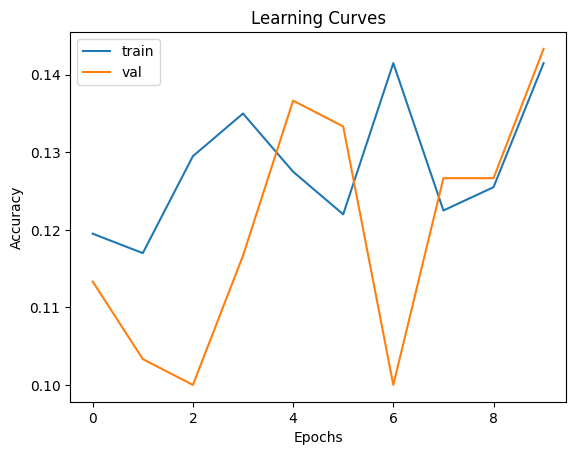

In [90]:
# ploting the learning curves
pyplot.title('Learning Curves')
pyplot.xlabel('Epochs')
pyplot.ylabel('Accuracy')
pyplot.plot(history_2.history['accuracy'], label='train')
pyplot.plot(history_2.history['val_accuracy'], label='val')
pyplot.legend()
pyplot.show()

In [ ]:
# evaluate the model
loss, accuracy = model.evaluate(test_data, test_labels, verbose=0)
print(f'Accuracy: {accuracy*100}')

Accuracy: 18.000000715255737


In [118]:
index = 3
yhat = model.predict([np.expand_dims(test_data[index], axis=0)], verbose = 0)
print('Predicted label: {}'.format(argmax(yhat)))
print('Actual label: {}'.format(test_labels[index]))

Predicted label: 3
Actual label: [2]


In [100]:
from tinymlgen import port

c_code = port(model, variable_name='model', pretty_print=True,optimize=False)
filename = 'net.h'
with open(filename,'w') as f:
    f.write(c_code)

In [119]:
test_data[3].flatten()

array([15, 12, 15,  2,  4, 15, 15,  3,  1,  8,  4,  5,  7,  2, 12, 11, 12,
        6, 15, 15,  2,  0, 11,  5, 15,  1,  8,  4,  7,  2,  5,  7, 10, 10,
        3,  1,  6, 13,  6,  0, 11,  2, 11,  9, 10,  1,  1,  9,  5,  7,  2,
        1,  6,  5,  7,  3,  5,  3,  1,  2, 15,  8, 10,  0], dtype=uint32)